# MinHash for recommendations

In the [previous notebook](04-minhash.ipynb) we saw how MinHash can be used to approximate the similarity of sets. In this notebook we will see that MinHash can also be used to make personalised recommendations to users.

We'll illustrate this technique using a data set which contains users' listening history from a music streaming service. If you're interested in how we generated the data, take a look at [this notebook](99a-data-generator.ipynb). 

In [1]:
import pandas as pd
import os.path

## Importing the data
df = pd.read_parquet(os.path.join("data", "userdat1.parquet"))
print(df.shape)

(3105450, 3)


The file contains three columns and over three million rows. Let's take a closer look at a sample of the data:

In [2]:
df.sample(10, random_state=1)

,user,artist,plays
1109,2916,119833,2
604,1209,144610,4
1110,2986,32390,4
86,843,61827,1
904,52,107100,190
1994,2034,158717,17
1371,838,166313,3
742,1051,147742,1
2910,1547,104013,95
919,1062,117048,12


The first column is an integer representing a user id, the second is an integer representing an artist name, and the third column is an integer indicating how many times the user listened to the artist. 

(It turns out that the artist and user ids are not currently stored as integers, but as strings instead. In the next cell we transform these to integers.)

In [3]:
df['artist'] = df['artist'].astype('int')
df['user'] = df['user'].astype('int')

We take one pass through the data frame to identify the set of unique users and the set of unique artists. 

In [4]:
artists = df['artist'].unique()
users = df['user'].unique()

In [5]:
print("There are ", len(artists), " artists and ", len(users), " users in our data." , sep="")

There are 34122 artists and 3100 users in our data.


We also load in a dictionary which maps from the artist integers to artist names. We will use this dictionary to map from the integers, representing artist names, back into artist names. 

In [6]:
import pickle
file = open("data/dartists.pkl","rb")
dartists = pickle.load(file)

We group the data by user. From there we can see which artists a particular user has listened to:

In [7]:
## grouping the data by user
grouped_df = df.groupby(['user']) 

## extracting user1's data:
user1 = grouped_df.get_group(1)
user1.sample(10)

,user,artist,plays
611,1,827,2
561,1,49465,1
349,1,27877,9
382,1,47724,12
613,1,95755,6
510,1,152621,169
542,1,22358,2
422,1,111951,4
456,1,106501,6
100,1,81865,7


The `artist_names` function maps from the integers to the names of the artist, using the dictionary we loaded in earlier. The `top_k_listens` function returns the names of the $k$ artists a particular user has listened to most:

In [8]:
import numpy as np

def artist_names(artist_ints, artist_dic = dartists):
    return [artist_dic[k] for k in artist_ints]


def top_k_listens(listening_history, k=10):
    """extracts the k most listened to artists in a given listening history"""
    top_k = listening_history.sort_values(by="plays", ascending = False)["artist"].head(k).values
    return artist_names(top_k)

In [9]:
top_k_listens(user1, 10) 

["Otomo Yoshihide'S New Jazz Ensemble",
 'M2J',
 'Deepspace',
 'Ian Pooley & Magik J',
 'Showbiz & A.G.',
 'The Odd Couple',
 'Monacles',
 'Puffy B.I.G. Lil Kim',
 '志方あきこ',
 'Solu Music']

So that's how we see what a particular user has listened to, but how do we use this to make recommendations? 

MinHash provides gives us a way to summarise set in a fixed amount of memory. If we create a MinHash signature of users’ listening history, we can identify similar users by comparing minhash signatures. 

One way to generate a MinHash signature for a user's listening history would be to add every artist the user has listened to into the MinHash signature for that user. In practise this works fine, but can be slow when users have listened to a large number of artists. 

Instead, we will use a faster function which works by pre-computing the MinHash signature for each artist, then generating a user's MinHash signature by combining the MinHash signatures for all of the artists that user has listened to. The code can be found in [this helper file](./datasketching/minhash.py).


In [10]:
from datasketching.minhash import generate_minhashes_for
from datasketching.minhash import LSHMinhash

In [11]:
mh_structs = LSHMinhash(32, 4) ## this is a MinHash signature with 32*4 = 128 Buckets. 
minhashes = generate_minhashes_for(grouped_df, "user", "artist", mh_structs)

In [12]:
print(len(minhashes))
minhashes[0][1] ## this is a minhash object. 

3100


We can compare MinHash signatures with the 'similarity' function. This returns a number between 0 and 1, where a `1` denotes identical signatures, and a `0` means that no corresponding buckets of the MinHash signatures hold the same value. 

In [13]:
minhashes[2][1].similarity(minhashes[1][1])

0.671875

Using the similarity, we can identify the set of users who are _most similar_ to the user we want to make recommendations for:

In [14]:
sim = []
for i in range(len(minhashes)):
    sim.append(minhashes[1][1].similarity(minhashes[i][1]))
    
similar = set(sorted(sim, reverse = True)[1:10])
similar_users = ([i for i, e in enumerate(sim) if e in similar])
for j in similar_users:
    print(users[j])

1
6
9
10
11
18
21
23
32
34
37
39


From there, we make recommendations by looking at the top artists listened to by all these users. We remove any artists user 1 already listened to, and recommend the others. 

In [15]:
unheard = []
for u in similar_users:
    u_dat = grouped_df.get_group(users[u])
    unheard = unheard + list(top_k_listens(u_dat, 2))

In [16]:
unheard

["Otomo Yoshihide'S New Jazz Ensemble",
 'M2J',
 'Avid Merrion',
 'S@M::&Lt;&Lt;::D.J. Sammy::&Gt;&Gt;::',
 'Pink Fairies',
 'Vesica Piscis',
 'David Ford',
 'Karp',
 'Laid',
 'Dj Tini Tun (We Are Here Records)',
 'Makyo',
 'Dub Sex',
 'Rain Tree Crow',
 'Neil Pepper',
 'Eighteen Visions',
 'Pages',
 'Chhaila',
 'Richie Furay',
 'Сергей Калачев',
 'Thy Serpent',
 'Bring Back The Guns',
 'Mad Contrabender',
 'André Herman Düne',
 'Tim Tim']

So that's just a quick example of how we can use minhash to identify artists we should recommend to a particular user. This method works fine on a small number of users, but falls into dificulty when the number of users grows, and the number of users for which we want to make recommendations for grows. 

Let's plot the time required to compare users:

In [17]:
import time
npairs = [10, 25, 50, 75, 100, 300, 500, 750, 1000, 2000, 3100] #number of users to compare
times = []
for pairs in npairs:
    start = time.time()
    sim=[]
    for i in range(1, pairs):
        for j in range((i+1), pairs):
            sim.append(minhashes[i][1].similarity(minhashes[j][1]))
    end = time.time()
    times.append((pairs, end-start))

In [18]:
times

[(10, 0.00010371208190917969),
 (25, 0.0004730224609375),
 (50, 0.0020151138305664062),
 (75, 0.004564046859741211),
 (100, 0.008741140365600586),
 (300, 0.0758061408996582),
 (500, 0.20188093185424805),
 (750, 0.451138973236084),
 (1000, 0.8161067962646484),
 (2000, 3.5307672023773193),
 (3100, 8.264407873153687)]

/anaconda2/envs/composable-recs/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


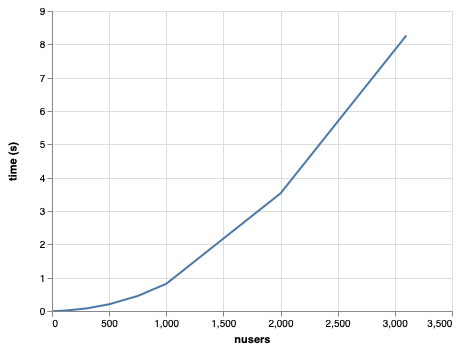

In [19]:
import altair as alt

times_df = pd.DataFrame.from_records(times)
times_df.rename(columns = {0:"nusers", 1:"time (s)"}, inplace = True)
alt.renderers.enable('notebook')
alt.Chart(times_df). mark_line().encode(x="nusers", y="time (s)")

## Locality-Sensitive Minhash

As the graph above shows, one big disadvantage of using Minhash signatures to identify similar users is the number of pairwise comparisons which must be made to determine similarity - Comparing 500 users takes less than half a second, but it takes nearly 8 seconds to compare 3000 users. This quadratic growth means that extensively comparing all users is not possible for real applications of this method with a non-trivial number of users. 

Locality-sensitive Minhash is a technique we can use to identify candidate pairs of similar users for a much smaller computational cost. The MinHash signature is split into subsets, and if two users have identical signatures in ANY of the subsets these users are considered a _candidate pair_. From there you can go and compute their approximate Jaccard index, or similarity, using the full minhash signatures, to determine just how similar they are, and decide if you want to make recommendations. 

In practice, the subsets into which we split the minhash signature are known as 'bands'. The contents of the bands are hashed to a set of buckets. Any two users who have at least one band which hashes to the same bucket are a candidate pair. 

In [20]:
from collections import defaultdict

bands = [defaultdict(lambda: list()) for i in range(len(mh_structs.lsh_keys()))]

for ind, lshm in minhashes:
    for idx, key in enumerate(lshm.lsh_keys()):
        bands[idx][key % (1 << 14)].append(ind)

We've made a dictionary of values for each band, where the keys correspond to buckets, and the values are indexes of minhash signature which mapped to that bucket. 

In [21]:
import itertools
candidates = []
for b in bands:
    for it in b.items():
        if len(it[1])>1:
            candidates.extend(list(itertools.combinations(it[1],2)))

`candidates` holds an extensive list of all candidate pairs of similar users. 

In [22]:
# extract set of users who are similar to _user_
def candidate_pairs(user, full_candidate_list):
    return set([y for x in [tup for tup in full_candidate_list if user in tup] for y in x]) - set([user])

In [25]:
len(candidate_pairs(1, full_candidate_list=candidates))

51

By using locality-sensitive MinHash we have reduced the number of pairwise comparisons needed from 3099 to 51, for user 1. 